In [54]:
import pandas as pd
import numpy as np 
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import plotly as px
from datetime import datetime
from datetime import timedelta
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline


Проект e-commerce: вариант 1
ПОСТАНОВКА ЗАДАЧИ:

Продакт-менеджер Василий попросил вас проанализировать совершенные покупки и ответить на следующие вопросы:

1. Сколько у нас пользователей, которые совершили покупку только один раз? (7 баллов)

2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? (5 баллов)

3. По каждому товару определить, в какой день недели товар чаще всего покупается. (5 баллов)

4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. (8 баллов)

5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц. Описание подхода можно найти (10 баллов)

6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, 
построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики:R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю. Описание подхода можно найти. (35 баллов)

 Для решения задачи проведи предварительное исследование данных и сформулируй, что должно считаться покупкой. Обосновать свой выбор ты можешь с помощью фактов оплат, статусов заказов и других имеющихся данных.

Файлы:
# olist_customers_datase.csv — таблица с уникальными идентификаторами пользователей

- **customer_id — позаказный идентификатор пользователя**

- **customer_unique_id —  уникальный идентификатор пользователя  (аналог номера паспорта)**

- **customer_zip_code_prefix —  почтовый индекс пользователя**

- **customer_city —  город доставки пользователя**

- **customer_state —  штат доставки пользователя**


# olist_orders_dataset.csv —  таблица заказов
- **order_id —  уникальный идентификатор заказа (номер чека)**

- **customer_id —  позаказный идентификатор пользователя**

- **order_status —  статус заказа**

- **order_purchase_timestamp —  время создания заказа**

- **order_approved_at —  время подтверждения оплаты заказа**

- **order_delivered_carrier_date —  время передачи заказа в логистическую службу**

- **order_delivered_customer_date —  время доставки заказа**

- **order_estimated_delivery_date —  обещанная дата доставки**


# olist_order_items_dataset.csv —  товарные позиции, входящие в заказы
- **order_id —  уникальный идентификатор заказа (номер чека)**

- **order_item_id —  идентификатор товара внутри одного заказа**

- **product_id —  ид товара (аналог штрихкода)**

- **seller_id — ид производителя товара**

- **shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике**

- **price —  цена за единицу товара**

- **freight_value —  вес товара**

— Пример структуры данных можно визуализировать по order_id == 00143d0f86d6fbd9f9b38ab440ac16f5

# Уникальные статусы заказов в таблице olist_orders_dataset:

- **created —  создан**
- **approved —  подтверждён**
- **invoiced —  выставлен счёт**
- **processing —  в процессе сборки заказа**
- **shipped —  отгружен со склада**
- **delivered —  доставлен пользователю**
- **unavailable —  недоступен**
- **canceled —  отменён**

In [2]:
olist_customers = pd.read_csv('olist_customers_dataset.csv')

In [3]:
olist_orders = pd.read_csv('olist_orders_dataset.csv', parse_dates=[3,4,5,6,7])

In [4]:
olist_items = pd.read_csv('olist_order_items_dataset.csv', parse_dates=['shipping_limit_date'])

таблицы olist_customers и olist_orders имеют общую колонку customer_id (позаказный идентификатор пользователя)

таблицы olist_items и olist_orders имеют общую колонку order_id (уникальный идентификатор заказа (номер чека))

Будет возможность смержить все три таблицы

Посмотрим на данные

In [5]:
olist_customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [6]:
olist_customers.duplicated().sum()

0

In [7]:
olist_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [8]:
olist_orders.duplicated().sum()

0

In [9]:
olist_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [10]:
olist_items.duplicated().sum()

0

Задача 1
Сколько у нас пользователей, которые совершили покупку только один раз?

Покупка-приобретение чего-либо за деньги. В нашем случае покупкой можно считать-товар оплачен и доставлен.


In [11]:
purchase = olist_orders.query('order_status == "delivered"').dropna(subset=['order_approved_at'])


In [12]:
purchase_and_customers = pd.merge(purchase, olist_customers, on = 'customer_id' )
purchase_and_customers.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP


In [13]:
purchase_and_customers.groupby('customer_unique_id', as_index=False) \
                        .agg({'order_id': 'count'}).order_id.value_counts()


1     90545
2      2572
3       181
4        28
5         9
6         5
7         3
15        1
9         1
Name: order_id, dtype: int64

# 90545 пользователей, которые совершили покупку только один раз.

Задача 2
Сколько заказов в месяц в среднем не доставляется по разным причинам? (вывести детализацию по причинам)

In [14]:
no_delivered = olist_orders.query("order_status != 'delivered'")
no_delivered.reset_index()

,index,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaT,NaT,2017-05-09
1,44,ee64d42b8cf066f35eac1cf57de1aa85,caded193e8e47b8362864762a83db3c5,shipped,2018-06-04 16:44:48,2018-06-05 04:31:18,2018-06-05 14:32:00,NaT,2018-06-28
2,103,0760a852e4e9d89eb77bf631eaaf1c84,d2a79636084590b7465af8ab374a8cf5,invoiced,2018-08-03 17:44:42,2018-08-07 06:15:14,NaT,NaT,2018-08-21
3,128,15bed8e2fec7fdbadb186b57c46c92f2,f3f0e613e0bdb9c7cee75504f0f90679,processing,2017-09-03 14:22:03,2017-09-03 14:30:09,NaT,NaT,2017-10-03
4,154,6942b8da583c2f9957e990d028607019,52006a9383bf149a4fb24226b173106f,shipped,2018-01-10 11:33:07,2018-01-11 02:32:30,2018-01-11 19:39:23,NaT,2018-02-07
...,...,...,...,...,...,...,...,...,...
2958,99283,3a3cddda5a7c27851bd96c3313412840,0b0d6095c5555fe083844281f6b093bb,canceled,2018-08-31 16:13:44,NaT,NaT,NaT,2018-10-01
2959,99313,e9e64a17afa9653aacf2616d94c005b8,b4cd0522e632e481f8eaf766a2646e86,processing,2018-01-05 23:07:24,2018-01-09 07:18:05,NaT,NaT,2018-02-06
2960,99347,a89abace0dcc01eeb267a9660b5ac126,2f0524a7b1b3845a1a57fcf3910c4333,canceled,2018-09-06 18:45:47,NaT,NaT,NaT,2018-09-27
2961,99348,a69ba794cc7deb415c3e15a0a3877e69,726f0894b5becdf952ea537d5266e543,unavailable,2017-08-23 16:28:04,2017-08-28 15:44:47,NaT,NaT,2017-09-15


In [15]:
pd.options.mode.chained_assignment = None

In [16]:
no_delivered['year_month'] = no_delivered['order_purchase_timestamp'].dt.strftime('%Y-%m')

no_delivered.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,year_month
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaT,NaT,2017-05-09,2017-04
44,ee64d42b8cf066f35eac1cf57de1aa85,caded193e8e47b8362864762a83db3c5,shipped,2018-06-04 16:44:48,2018-06-05 04:31:18,2018-06-05 14:32:00,NaT,2018-06-28,2018-06
103,0760a852e4e9d89eb77bf631eaaf1c84,d2a79636084590b7465af8ab374a8cf5,invoiced,2018-08-03 17:44:42,2018-08-07 06:15:14,NaT,NaT,2018-08-21,2018-08
128,15bed8e2fec7fdbadb186b57c46c92f2,f3f0e613e0bdb9c7cee75504f0f90679,processing,2017-09-03 14:22:03,2017-09-03 14:30:09,NaT,NaT,2017-10-03,2017-09
154,6942b8da583c2f9957e990d028607019,52006a9383bf149a4fb24226b173106f,shipped,2018-01-10 11:33:07,2018-01-11 02:32:30,2018-01-11 19:39:23,NaT,2018-02-07,2018-01


In [17]:
no_delivered_month = no_delivered.groupby(['year_month', 'order_status']).agg({'order_id': 'count'}).reset_index()
no_delivered_month.head()

,year_month,order_status,order_id
0,2016-09,canceled,2
1,2016-09,shipped,1
2,2016-10,canceled,24
3,2016-10,invoiced,18
4,2016-10,processing,2


In [18]:
no_delivered_month_mean = no_delivered_month.groupby(['order_status']).agg({'order_id': 'mean'}).sort_values('order_id', ascending=False)
gr = no_delivered_month_mean.reset_index()
gr.columns = ['order_status', 'order_mean']
gr

,order_status,order_mean
0,shipped,48.130435
1,unavailable,29.000000
2,canceled,26.041667
3,processing,15.842105
4,invoiced,14.952381
5,created,1.666667
6,approved,1.000000


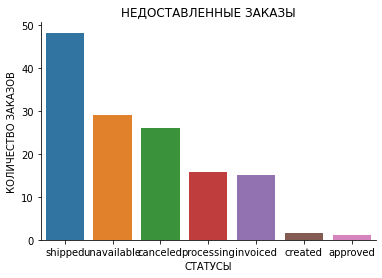

In [19]:
sns.barplot(x='order_status',y='order_mean',data=gr)
plt.title('НЕДОСТАВЛЕННЫЕ ЗАКАЗЫ')
plt.xlabel('СТАТУСЫ')
plt.ylabel('КОЛИЧЕСТВО ЗАКАЗОВ')
sns.despine()


Задача 3
По каждому товару определить, в какой день недели товар чаще всего покупается

In [20]:
order_day = pd.merge(purchase, olist_items, how='left', on = 'order_id' )
order_day['day'] = order_day['order_approved_at'].dt.day_name()
order_day.head()


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,day
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,Monday
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,Thursday
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,Wednesday
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,1,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20,Saturday
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,1,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72,Tuesday


In [21]:
order_count_day = order_day\
                .groupby(['product_id', 'day'], as_index = False)\
                .agg({'order_id':'count'})
order_count_day

,product_id,day,order_id
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday,1
1,00088930e925c41fd95ebfe695fd2655,Tuesday,1
2,0009406fd7479715e4bef61dd91f2462,Friday,1
3,000b8f95fcb9e0096488278317764d19,Friday,1
4,000b8f95fcb9e0096488278317764d19,Wednesday,1
...,...,...,...
59831,fff9553ac224cec9d15d49f5a263411f,Saturday,1
59832,fffdb2d0ec8d6a61f0a0a0db3f25b441,Friday,1
59833,fffdb2d0ec8d6a61f0a0a0db3f25b441,Thursday,1
59834,fffdb2d0ec8d6a61f0a0a0db3f25b441,Tuesday,3


In [22]:
order_max_day = pd.pivot_table(order_count_day, index=['product_id'], columns=['day'], values=['order_id'], aggfunc=[np.max], fill_value=0)
order_max_day 

amax                                  \
                                 order_id                                   
day                                Friday Monday Saturday Sunday Thursday   
product_id                                                                  
00066f42aeeb9f3007548bb9d3f33c38        0      0        0      1        0   
00088930e925c41fd95ebfe695fd2655        0      0        0      0        0   
0009406fd7479715e4bef61dd91f2462        1      0        0      0        0   
000b8f95fcb9e0096488278317764d19        1      0        0      0        0   
000d9be29b5207b54e86aa1b1ac54872        0      0        0      0        0   
...                                   ...    ...      ...    ...      ...   
fff6177642830a9a94a0f2cba5e476d1        0      1        1      0        0   
fff81cc3158d2725c0655ab9ba0f712c        0      1        0      0        0   
fff9553ac224cec9d15d49f5a263411f        0      0        1      0        0   
fffdb2d0ec8d6a61f0a0a0db3f25b441        1      0        0      0        1   
fffe9eeff12fcbd74a2f2b007dde0c58        0      0        0      0        0   

                                                    
                                                    
day                              Tuesday Wednesday  
product_id                                          
00066f42aeeb9f3007548bb9d3f33c38       0         0  
00088930e925c41fd95ebfe695fd2655       1         0  
0009406fd7479715e4bef61dd91f2462       0         0  
000b8f95fcb9e0096488278317764d19       0         1  
000d9be29b5207b54e86aa1b1ac54872       1         0  
...                                  ...       ...  
fff6177642830a9a94a0f2cba5e476d1       0         0  
fff81cc3158d2725c0655ab9ba0f712c       0         0  
fff9553ac224cec9d15d49f5a263411f       0         0  
fffdb2d0ec8d6a61f0a0a0db3f25b441       3         0  
fffe9eeff12fcbd74a2f2b007dde0c58       0         1  

[32213 rows x 7 columns]

По каждому продукту выведено max количество заказов по дням

In [23]:
order_max_day.describe()

amax                                                          \
           order_id                                                           
day          Friday        Monday      Saturday        Sunday      Thursday   
count  32213.000000  32213.000000  32213.000000  32213.000000  32213.000000   
mean       0.507373      0.444634      0.419955      0.305777      0.537857   
std        1.775713      1.475561      1.514212      1.085334      1.832037   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        1.000000      1.000000      0.000000      0.000000      1.000000   
max       92.000000     73.000000     70.000000     53.000000     80.000000   

                                   
                                   
day         Tuesday     Wednesday  
count  32213.000000  32213.000000  
mean       0.662434      0.542390  
std        2.277374      1.869147  
min        0.000000      0.000000  
25%        0.000000      0.000000  
50%        0.000000      0.000000  
75%        1.000000      1.000000  
max      119.000000     87.000000

Общая статистика 


Задача 4
Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.

In [24]:
purchase_month = purchase_and_customers[['customer_unique_id', 'order_id', 'order_approved_at']]
purchase_month.head()

,customer_unique_id,order_id,order_approved_at
0,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 11:07:15
1,af07308b275d755c9edb36a90c618231,53cdb2fc8bc7dce0b6741e2150273451,2018-07-26 03:24:27
2,3a653a41f6f9fc3d2a113cf8398680e8,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:55:23
3,7c142cf63193a1473d2e66489a9ae977,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:45:59
4,72632f0f9dd73dfee390c9b22eb56dd6,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 22:20:29


In [25]:
purchase_month['year_month'] = purchase_month['order_approved_at'].dt.strftime('%Y-%m')
purchase_month.head()

,customer_unique_id,order_id,order_approved_at,year_month
0,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 11:07:15,2017-10
1,af07308b275d755c9edb36a90c618231,53cdb2fc8bc7dce0b6741e2150273451,2018-07-26 03:24:27,2018-07
2,3a653a41f6f9fc3d2a113cf8398680e8,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:55:23,2018-08
3,7c142cf63193a1473d2e66489a9ae977,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:45:59,2017-11
4,72632f0f9dd73dfee390c9b22eb56dd6,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 22:20:29,2018-02


In [26]:
purchase_month['month'] = purchase_month['order_approved_at'].dt.month_name()
purchase_month['week'] = purchase_month['order_approved_at'].dt.daysinmonth/7 # расчитываем кол-во недель в месяце
purchase_month_week = purchase_month[['customer_unique_id', 'order_id', 'year_month', 'month', 'week']]

purchase_month_week.head()

,customer_unique_id,order_id,year_month,month,week
0,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,2017-10,October,4.428571
1,af07308b275d755c9edb36a90c618231,53cdb2fc8bc7dce0b6741e2150273451,2018-07,July,4.428571
2,3a653a41f6f9fc3d2a113cf8398680e8,47770eb9100c2d0c44946d9cf07ec65d,2018-08,August,4.428571
3,7c142cf63193a1473d2e66489a9ae977,949d5b44dbf5de918fe9c16f97b45f8a,2017-11,November,4.285714
4,72632f0f9dd73dfee390c9b22eb56dd6,ad21c59c0840e6cb83a9ceb5573f8159,2018-02,February,4.000000


In [27]:
purchase_per_week_mean = purchase_month_week.groupby(['customer_unique_id','year_month','month','week'],as_index=False)\
            .agg({'order_id':'count'})\
            .rename(columns={'order_id':'order_month'})\
            .sort_values('year_month')
purchase_per_week_mean['mean_week'] = purchase_per_week_mean.order_month / purchase_per_week_mean.week

purchase_per_week_mean 

,customer_unique_id,year_month,month,week,order_month,mean_week
48809,830d5b7aaa3b6f1e9ad63703bec97d23,2016-09,September,4.285714,1,0.233333
66808,b3724b93edd00e472e1db7017236f60a,2016-10,October,4.428571,1,0.225806
88214,ecf55c92c7bf73cc1d576a0f6a235b0b,2016-10,October,4.428571,1,0.225806
3454,0922f37485310929b1b94e8f0c984ca5,2016-10,October,4.428571,1,0.225806
6617,11a40baf46bd96289d1f0936dae9a256,2016-10,October,4.428571,1,0.225806
...,...,...,...,...,...,...
10878,1d0be6ff723818bb810023b236405017,2018-08,August,4.428571,1,0.225806
7269,1366e41e0208f2e7cd74492ce529ef34,2018-08,August,4.428571,1,0.225806
60275,a2058e072a55d42210fcdb91d837c65c,2018-08,August,4.428571,1,0.225806
65804,b0b7a87b0b0c394965bd49368aefed80,2018-08,August,4.428571,1,0.225806


Посчитали среднее число заказов в неделю для каждого пользователя по году и месяцу.

Задача 5
Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц.

# retention(удержание)
- Retention rate — это коэффициент удержания пользователей. Он показывает, сколько клиентов возвращается за определённый период. Это одна из главных метрик маркетинга. 

Перед проведением когортного анализа определяют четыре параметра:
1. Признак формирования когорты - первая покупка 
2. Размер когорты — месяц
3. Отчетный период - 12 месяцев(один год)
4. Анализируемый ключевой показатель: Retention 

In [28]:
purchase_and_customers.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP


In [29]:
template_cogort = purchase_and_customers[['customer_unique_id', 'order_approved_at', 'order_id']]
template_cogort['year_month'] = template_cogort['order_approved_at'].dt.strftime('%Y-%m')
template_cogort.head()

,customer_unique_id,order_approved_at,order_id,year_month
0,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 11:07:15,e481f51cbdc54678b7cc49136f2d6af7,2017-10
1,af07308b275d755c9edb36a90c618231,2018-07-26 03:24:27,53cdb2fc8bc7dce0b6741e2150273451,2018-07
2,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08 08:55:23,47770eb9100c2d0c44946d9cf07ec65d,2018-08
3,7c142cf63193a1473d2e66489a9ae977,2017-11-18 19:45:59,949d5b44dbf5de918fe9c16f97b45f8a,2017-11
4,72632f0f9dd73dfee390c9b22eb56dd6,2018-02-13 22:20:29,ad21c59c0840e6cb83a9ceb5573f8159,2018-02


In [30]:
# Посчитаем первую покупку пользователя
template_cogort.set_index('customer_unique_id', inplace=True)
template_cogort['first_buy'] = template_cogort.groupby(level=0)['order_approved_at'].min().dt.strftime('%Y-%m') 
template_cogort.reset_index(inplace=True)
template_cogort.head()

,customer_unique_id,order_approved_at,order_id,year_month,first_buy
0,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 11:07:15,e481f51cbdc54678b7cc49136f2d6af7,2017-10,2017-09
1,af07308b275d755c9edb36a90c618231,2018-07-26 03:24:27,53cdb2fc8bc7dce0b6741e2150273451,2018-07,2018-07
2,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08 08:55:23,47770eb9100c2d0c44946d9cf07ec65d,2018-08,2018-08
3,7c142cf63193a1473d2e66489a9ae977,2017-11-18 19:45:59,949d5b44dbf5de918fe9c16f97b45f8a,2017-11,2017-11
4,72632f0f9dd73dfee390c9b22eb56dd6,2018-02-13 22:20:29,ad21c59c0840e6cb83a9ceb5573f8159,2018-02,2018-02


In [31]:
first = template_cogort.groupby(['first_buy', 'year_month'])
cogort = first.agg({'customer_unique_id': pd.Series.nunique,
                        'order_id': 'count'})
cogort.rename(columns={'customer_unique_id': 'users',
                         'order_id': 'orders'}, inplace=True)
cogort.head()

users  orders
first_buy year_month               
2016-09   2016-09         1       1
2016-10   2016-10       262     265
          2017-04         1       1
          2017-07         1       1
          2017-09         1       1

In [32]:
def period(df):
    df['cogort_period'] = np.arange(len(df))
    return df
cogort = cogort.groupby(level=0).apply(period)
cogort

users  orders  cogort_period
first_buy year_month                              
2016-09   2016-09         1       1              0
2016-10   2016-10       262     265              0
          2017-04         1       1              1
          2017-07         1       1              2
          2017-09         1       1              3
...                     ...     ...            ...
2018-06   2018-07        23      23              1
          2018-08        16      17              2
2018-07   2018-07      5846    5904              0
          2018-08        30      30              1
2018-08   2018-08      6290    6329              0

[219 rows x 3 columns]

In [33]:
cogort_period = cogort.query('cogort_period < 13')
cogort_period.reset_index(inplace=True)
cogort_period.set_index(['cogort_period', 'first_buy'], inplace=True)
cogort_period

year_month  users  orders
cogort_period first_buy                          
0             2016-09      2016-09      1       1
              2016-10      2016-10    262     265
1             2016-10      2017-04      1       1
2             2016-10      2017-07      1       1
3             2016-10      2017-09      1       1
...                            ...    ...     ...
1             2018-06      2018-07     23      23
2             2018-06      2018-08     16      17
0             2018-07      2018-07   5846    5904
1             2018-07      2018-08     30      30
0             2018-08      2018-08   6290    6329

[194 rows x 3 columns]

In [34]:
cogort_group = cogort_period['users'].groupby(level=1).first()
cogort_period['users'].unstack(0)

cogort_period,0,1,2,3,4,5,6,7,8,9,10,11,12
first_buy,,,,,,,,,,,,,
2016-09,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,262.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,NaN,NaN,NaN,NaN
2016-12,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,683.0,3.0,2.0,1.0,3.0,1.0,3.0,1.0,1.0,2.0,2.0,5.0,3.0
2017-02,1612.0,3.0,4.0,3.0,7.0,2.0,4.0,3.0,1.0,3.0,2.0,5.0,2.0
2017-03,2511.0,11.0,9.0,9.0,9.0,4.0,4.0,8.0,7.0,3.0,9.0,3.0,5.0
2017-04,2232.0,14.0,5.0,4.0,5.0,6.0,8.0,6.0,8.0,4.0,5.0,2.0,1.0
2017-05,3453.0,18.0,16.0,10.0,10.0,11.0,14.0,5.0,9.0,9.0,10.0,12.0,6.0
2017-06,3044.0,15.0,12.0,13.0,9.0,11.0,11.0,7.0,4.0,6.0,9.0,12.0,5.0


In [35]:
retention = np.round((cogort_period['users'].unstack(0).div(cogort_group, axis=0))*100, 2)
retention

cogort_period,0,1,2,3,4,5,6,7,8,9,10,11,12
first_buy,,,,,,,,,,,,,
2016-09,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,100.0,0.38,0.38,0.38,0.38,0.38,0.38,0.76,0.76,NaN,NaN,NaN,NaN
2016-12,100.0,100.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,100.0,0.44,0.29,0.15,0.44,0.15,0.44,0.15,0.15,0.29,0.29,0.73,0.44
2017-02,100.0,0.19,0.25,0.19,0.43,0.12,0.25,0.19,0.06,0.19,0.12,0.31,0.12
2017-03,100.0,0.44,0.36,0.36,0.36,0.16,0.16,0.32,0.28,0.12,0.36,0.12,0.20
2017-04,100.0,0.63,0.22,0.18,0.22,0.27,0.36,0.27,0.36,0.18,0.22,0.09,0.04
2017-05,100.0,0.52,0.46,0.29,0.29,0.32,0.41,0.14,0.26,0.26,0.29,0.35,0.17
2017-06,100.0,0.49,0.39,0.43,0.30,0.36,0.36,0.23,0.13,0.20,0.30,0.39,0.16


На 3й месяц Retention(коэффициент удержания клиентов) максимален у кагорты 2017-06 и равен 0.43%

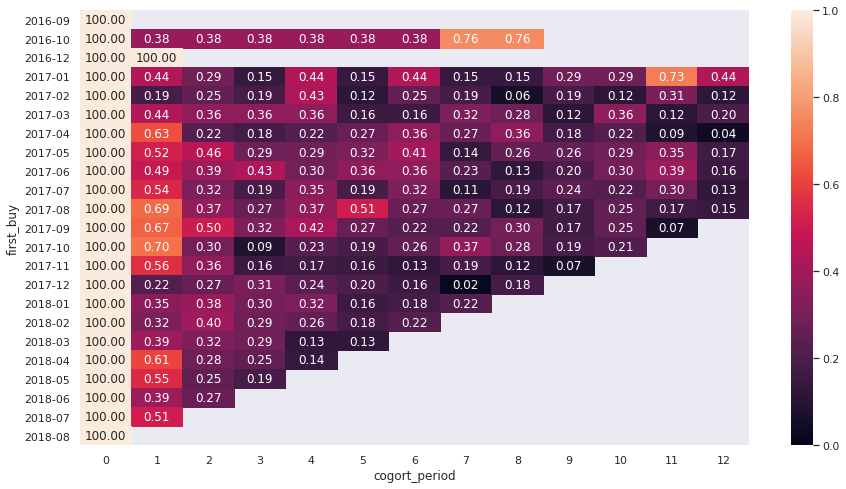

In [45]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(retention, annot=True, fmt=".2f", vmin=0, vmax=1)


Задача 6
Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики:
# R - время от последней покупки пользователя до текущей даты,

# F - суммарное количество покупок у пользователя за всё время,

# M - сумма покупок за всё время.

Подробно опиши, как ты создавал кластеры.

# Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров.

Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней,

frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю

In [46]:
olist_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [47]:
paid_order = olist_items.groupby('order_id', as_index = False)\
            .agg({'price':'sum'})\
            .rename(columns={'price':'paid_order'})
paid_order.head()

,order_id,paid_order
0,00010242fe8c5a6d1ba2dd792cb16214,58.90
1,00018f77f2f0320c557190d7a144bdd3,239.90
2,000229ec398224ef6ca0657da4fc703e,199.00
3,00024acbcdf0a6daa1e931b038114c75,12.99
4,00042b26cf59d7ce69dfabb4e55b4fd9,199.90


In [48]:
# мерджим 2 дф с суммой заказа и клиентами с покупками
paid_order_custmores = pd.merge(purchase_and_customers, paid_order, how='left', on = 'order_id' )
paid_order_custmores.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,paid_order
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,29.99
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,118.70
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,159.90
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,45.00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,19.90


In [49]:
# берем только нужное
paid_order_custmores = paid_order_custmores.loc[pd.isna(paid_order_custmores.paid_order) == False]
paid_order_custmores = paid_order_custmores[['customer_unique_id','order_id','order_approved_at','paid_order']]
paid_order_custmores.head()

,customer_unique_id,order_id,order_approved_at,paid_order
0,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 11:07:15,29.99
1,af07308b275d755c9edb36a90c618231,53cdb2fc8bc7dce0b6741e2150273451,2018-07-26 03:24:27,118.70
2,3a653a41f6f9fc3d2a113cf8398680e8,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:55:23,159.90
3,7c142cf63193a1473d2e66489a9ae977,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:45:59,45.00
4,72632f0f9dd73dfee390c9b22eb56dd6,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 22:20:29,19.90


In [50]:
# последняя дата оплаты заказа
last_date = paid_order_custmores['order_approved_at'].max()
last_date

Timestamp('2018-08-29 15:10:26')

In [75]:

RFM = paid_order_custmores.reset_index().groupby('customer_unique_id')\
            .agg({'order_approved_at': lambda x: (last_date - x.max()).days,
                           'order_id': 'count', 
                             'paid_order': 'sum'})
RFM.rename(columns={'order_approved_at': 'recency', 
                          'order_id': 'frequency', 
                          'paid_order': 'monetary'}, inplace=True)
RFM

,recency,frequency,monetary
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,111,1,129.90
0000b849f77a49e4a4ce2b2a4ca5be3f,113,1,18.90
0000f46a3911fa3c0805444483337064,536,1,69.00
0000f6ccb0745a6a4b88665a16c9f078,320,1,25.99
0004aac84e0df4da2b147fca70cf8255,287,1,180.00
...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,446,1,1570.00
fffea47cd6d3cc0a88bd621562a9d061,261,1,64.89
ffff371b4d645b6ecea244b27531430a,567,1,89.90


In [65]:
# посмотрим статистику
RFM.describe()

,recency,frequency,monetary
count,93345.000000,93345.000000,93345.000000
mean,236.478879,1.033414,141.623308
std,152.571000,0.209088,215.705007
min,0.000000,1.000000,0.850000
25%,113.000000,1.000000,47.650000
50%,218.000000,1.000000,89.760000
75%,345.000000,1.000000,154.750000
max,713.000000,15.000000,13440.000000


Посмотрим графики распределения по основным метрикам 

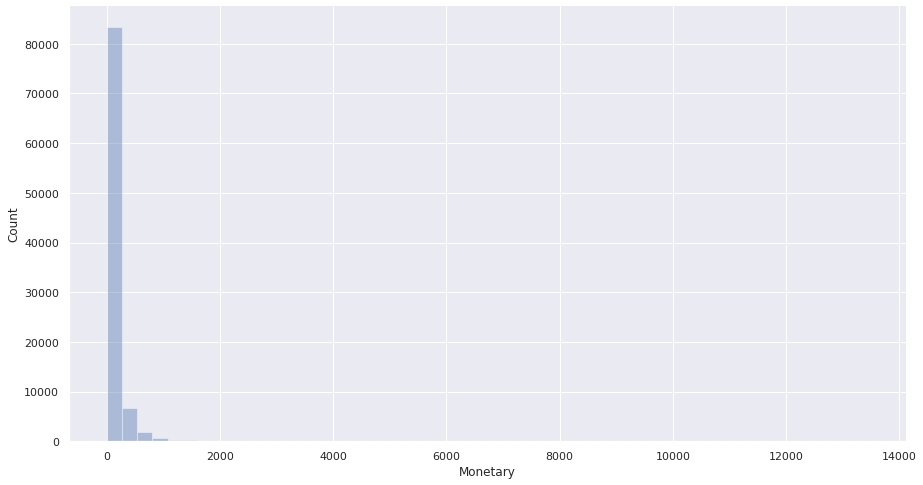

In [66]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.distplot(RFM.monetary, kde=False)
plt.xlabel('Monetary')
plt.ylabel('Count')
sns.despine()

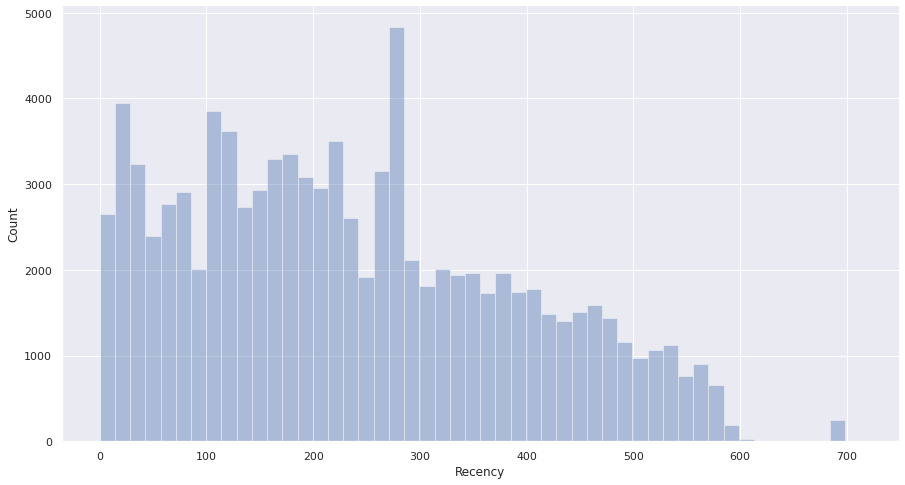

In [67]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.distplot(RFM.recency, kde=False)
plt.xlabel('Recency')
plt.ylabel('Count')
sns.despine()

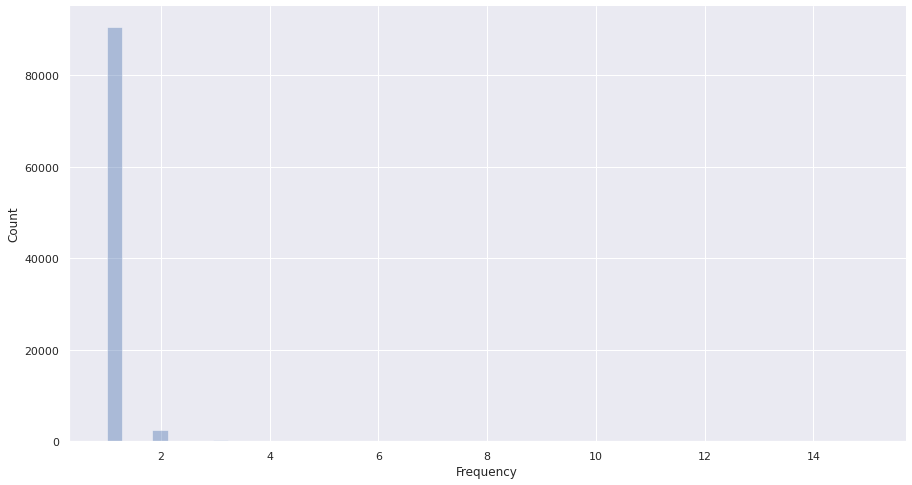

In [68]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.distplot(RFM.frequency, kde=False)
plt.xlabel('Frequency')
plt.ylabel('Count')
sns.despine()

In [76]:
quintiles = RFM[['recency', 'frequency', 'monetary']].quantile([.2, .4, .6, .8]).to_dict()
quintiles

{'recency': {0.2: 91.0, 0.4: 176.0, 0.6: 267.0, 0.8: 380.1999999999971},
 'frequency': {0.2: 1.0, 0.4: 1.0, 0.6: 1.0, 0.8: 1.0},
 'monetary': {0.2: 39.9, 0.4: 69.9, 0.6: 109.9, 0.8: 179.9}}

Затем надо написать методы для присвоения рангов от 1 до 5. Меньшее значение новизны лучше, тогда как более высокая частота и денежные значения лучше. Мне нужно написать два отдельных метода.

In [77]:
def r_score(x):
    if x <= quintiles['recency'][.2]:
        return 5
    elif x <= quintiles['recency'][.4]:
        return 4
    elif x <= quintiles['recency'][.6]:
        return 3
    elif x <= quintiles['recency'][.8]:
        return 2
    else:
        return 1

def fm_score(x, c):
    if x <= quintiles[c][.2]:
        return 1
    elif x <= quintiles[c][.4]:
        return 2
    elif x <= quintiles[c][.6]:
        return 3
    elif x <= quintiles[c][.8]:
        return 4
    else:
        return 5    

Теперь можно получить оценки R, F и M каждого клиента.

In [78]:
RFM['R'] = RFM['recency'].apply(lambda x: r_score(x))
RFM['F'] = RFM['frequency'].apply(lambda x: fm_score(x, 'frequency'))
RFM['M'] = RFM['monetary'].apply(lambda x: fm_score(x, 'monetary'))

Получение сегментов клиентов из оценки RFM

In [79]:
RFM['RFM Score'] = RFM['R'].map(str) + RFM['F'].map(str) + RFM['M'].map(str)
RFM.head()

,recency,frequency,monetary,R,F,M,RFM Score
customer_unique_id,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,111,1,129.90,4,1,4,414
0000b849f77a49e4a4ce2b2a4ca5be3f,113,1,18.90,4,1,1,411
0000f46a3911fa3c0805444483337064,536,1,69.00,1,1,2,112
0000f6ccb0745a6a4b88665a16c9f078,320,1,25.99,2,1,1,211
0004aac84e0df4da2b147fca70cf8255,287,1,180.00,2,1,5,215


Оценки RFM дают нам 53 = 125 сегментов. С которым нелегко работать.
Я собираюсь работать с 11 сегментами на основе оценок R и F. Вот описание сегментов:

* Сегмент	Описание
* Чемпионы	*Купил недавно, покупайте часто и тратьте больше всего
* Постоянные клиенты	*Покупайте на регулярной основе. Реагирует на рекламные акции.
* Потенциальный лоялист	*Недавние клиенты со средней частотой.
* Недавние клиенты	*Покупается совсем недавно, но не часто.
* Многообещающий	*Недавние покупатели, но потратили не так много.
* Клиенты, нуждающиеся во внимании	*Новизна, частота и денежные показатели выше среднего. Возможно, я купил его не совсем недавно.
* Собираюсь спать	*Новизна и частота ниже среднего. Они будут потеряны, если не будут повторно активированы.
* В опасности	*Приобретался часто, но очень давно. Нужно вернуть их обратно!
* Не могу их потерять	*Раньше часто покупал, но долгое время не возвращался.
* Переход в спящий режим	*Последняя покупка была долгой и с низким количеством заказов. Может быть потерян.

In [81]:
segt_map = {
    r'[1-2][1-2]': 'Переход в спящий режим',
    r'[1-2][3-4]': 'В опасности',
    r'[1-2]5': 'Не могу их потерять',
    r'3[1-2]': 'Собираюсь спать',
    r'33': 'Клиенты, нуждающиеся во внимании',
    r'[3-4][4-5]': 'Постоянные клиенты',
    r'41': 'Многообещающий',
    r'51': 'Недавние клиенты',
    r'[4-5][2-3]': 'Потенциальный лоялист',
    r'5[4-5]': 'Чемпионы'
}

RFM['Segment'] = RFM['R'].map(str) + RFM['F'].map(str)
RFM['Segment'] = RFM['Segment'].replace(segt_map, regex=True)
RFM.head()


,recency,frequency,monetary,R,F,M,RFM Score,Segment
customer_unique_id,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,111,1,129.90,4,1,4,414,Многообещающий
0000b849f77a49e4a4ce2b2a4ca5be3f,113,1,18.90,4,1,1,411,Многообещающий
0000f46a3911fa3c0805444483337064,536,1,69.00,1,1,2,112,Переход в спящий режим
0000f6ccb0745a6a4b88665a16c9f078,320,1,25.99,2,1,1,211,Переход в спящий режим
0004aac84e0df4da2b147fca70cf8255,287,1,180.00,2,1,5,215,Переход в спящий режим


# Визуализация 
Теперь, когда у нас есть результаты, мы можем выполнить некоторую визуализацию данных, чтобы получить лучшее представление о портфолио наших клиентов. Сначала давайте посмотрим на распределение R, F и M.



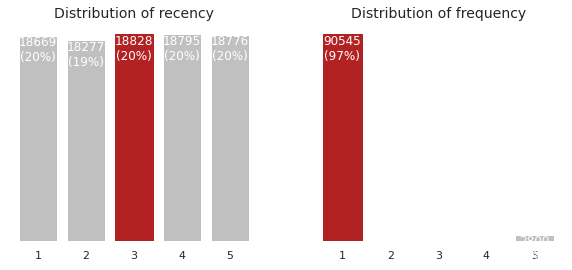

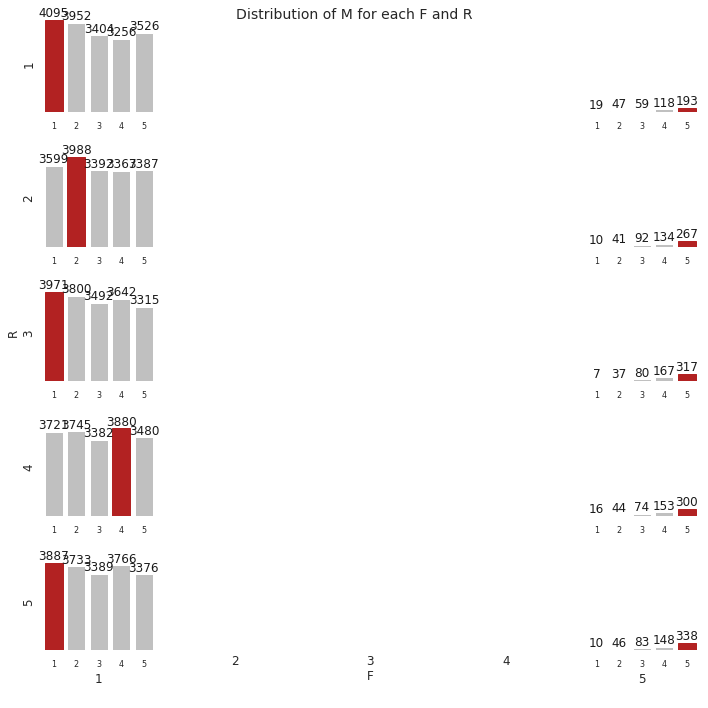

In [82]:
# построим график распределения клиентов по R и F
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

for i, p in enumerate(['R', 'F']):
    parameters = {'R':'recency', 'F':'frequency'}
    y = RFM[p].value_counts().sort_index()
    x = y.index
    ax = axes[i]
    bars = ax.bar(x, y, color='silver')
    ax.set_frame_on(False)
    ax.tick_params(left=False, labelleft=False, bottom=False)
    ax.set_title('Distribution of {}'.format(parameters[p]),
                fontsize=14)
    for bar in bars:
        value = bar.get_height()
        if value == y.max():
            bar.set_color('firebrick')
        ax.text(bar.get_x() + bar.get_width() / 2,
                value - 5,
                '{}\n({}%)'.format(int(value), int(value * 100 / y.sum())),
               ha='center',
               va='top',
               color='w')

plt.show()

# построим график распределения M для оценки RF
fig, axes = plt.subplots(nrows=5, ncols=5,
                         sharex=False, sharey=True,
                         figsize=(10, 10))

r_range = range(1, 6)
f_range = range(1, 6)
for r in r_range:
    for f in f_range:
        y = RFM[(RFM['R'] == r) & (RFM['F'] == f)]['M'].value_counts().sort_index()
        x = y.index
        ax = axes[r - 1, f - 1]
        bars = ax.bar(x, y, color='silver')
        if r == 5:
            if f == 3:
                ax.set_xlabel('{}\nF'.format(f), va='top')
            else:
                ax.set_xlabel('{}\n'.format(f), va='top')
        if f == 1:
            if r == 3:
                ax.set_ylabel('R\n{}'.format(r))
            else:
                ax.set_ylabel(r)
        ax.set_frame_on(False)
        ax.tick_params(left=False, labelleft=False, bottom=False)
        ax.set_xticks(x)
        ax.set_xticklabels(x, fontsize=8)

        for bar in bars:
            value = bar.get_height()
            if value == y.max():
                bar.set_color('firebrick')
            ax.text(bar.get_x() + bar.get_width() / 2,
                    value,
                    int(value),
                    ha='center',
                    va='bottom',
                    color='k')
fig.suptitle('Distribution of M for each F and R',
             fontsize=14)
plt.tight_layout()
plt.show()

Посмотрим на распределение наших сегментов построим столбчатые диаграммы

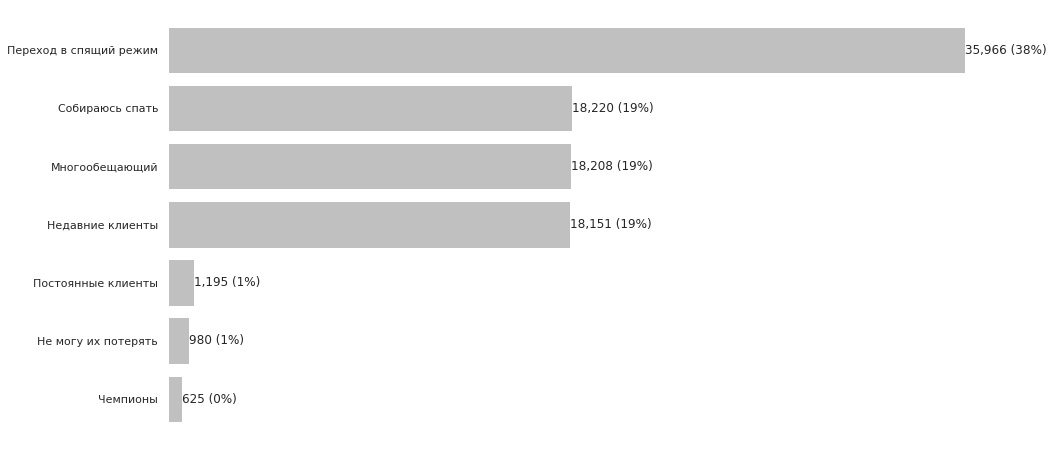

In [84]:
# подсчитаем количество клиентов в каждом сегменте
segments_counts = RFM['Segment'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color='silver')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        if segments_counts.index[i] in ['champions', 'loyal customers']:
            bar.set_color('firebrick')
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                   int(value*100/segments_counts.sum())),
                va='center',
                ha='left'
               )

plt.show()

У нас много клиентов, которые переходят в спящий режим 38%. К сожалению, 1% наших клиентов являются либо чемпионами, либо постоянными клиентами. 